Shape: (1000, 15)
[0.00169034 0.00978576 0.01114108 0.03564451 0.00921554 0.13728193
 0.00105559 0.08591284 0.2987218  0.02303728 0.26604016 0.10231844
 0.01256621 0.0536246  0.19120615]


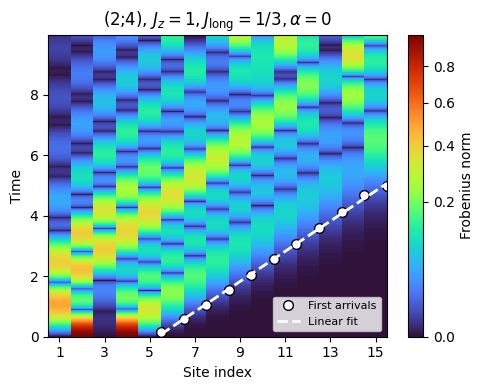

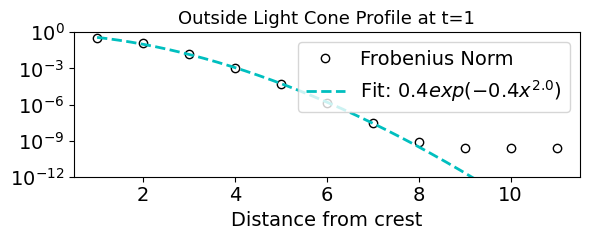

profile [3.16764738e-01 1.23455246e-01 1.65856239e-02 1.15465288e-03
 4.95375244e-05 1.44582699e-06 3.08424175e-08 7.31015248e-10
 2.45403697e-10 2.39186448e-10 2.39208653e-10]


In [21]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffJlong03b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.15),
    (6, 0.57),
    (7, 1.04),
    (8, 1.54),
    (9, 2.05),
    (10, 2.56),
    (11, 3.08),
    (12, 3.59),
    (13, 4.11),
    (14, 4.67),
    (15, 4.97)
]



x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=1/3, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong03b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${0.4:.1f}exp({{-{0.4:.1f} x^{{{2.0:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-12, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong03b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (1000, 15)
[0.00169556 0.00973785 0.01118359 0.03554611 0.00921098 0.13706884
 0.00104429 0.08576576 0.29799486 0.02327354 0.26582955 0.10235267
 0.01252868 0.05405112 0.19042808]


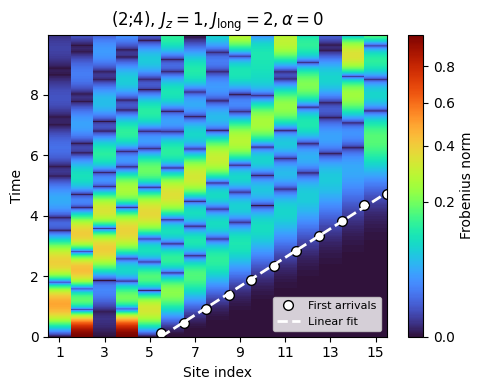

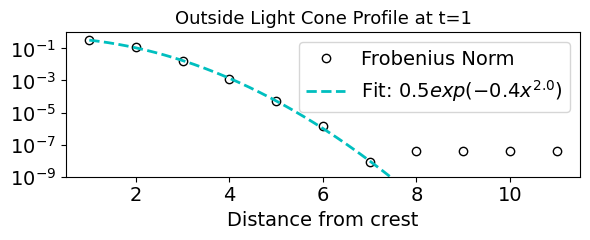

profile [3.16732585e-01 1.23405232e-01 1.65753346e-02 1.15369801e-03
 4.94519976e-05 1.40522121e-06 8.27840019e-09 3.83553855e-08
 3.88405974e-08 3.88466148e-08 3.88468147e-08]


In [22]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffJlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (5, 0.11),
    (6, 0.47),
    (7, 0.91),
    (8, 1.38),
    (9, 1.86),
    (10, 2.35),
    (11, 2.84),
    (12, 3.34),
    (13, 3.84),
    (14, 4.37),
    (15, 4.72)
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.01   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-9, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffJlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 15)
[0.00151441 0.01041284 0.00989249 0.03629725 0.00886489 0.1368075
 0.00128016 0.0858718  0.30342873 0.01725701 0.26103697 0.0979593
 0.01276057 0.04302939 0.20072576]


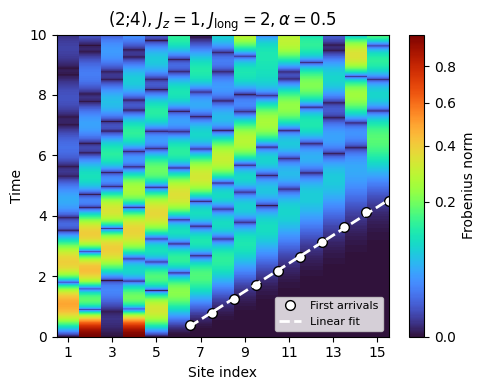

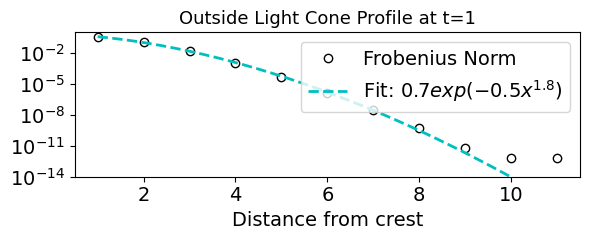

profile [3.16764717e-01 1.23455283e-01 1.65856311e-02 1.15465297e-03
 4.95372710e-05 1.44558521e-06 3.06023873e-08 4.91184871e-10
 5.59552404e-12 5.99520433e-13 5.99520433e-13]


In [24]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffa05Jlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (6, 0.39),
    (7, 0.80),
    (8, 1.24),
    (9, 1.70),
    (10, 2.17),
    (11, 2.65),
    (12, 3.13),
    (13, 3.62),
    (14, 4.12),
    (15, 4.49)
]




x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=0.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa05Jlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa05Jlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)

Shape: (10000, 15)
[0.09577823 0.06171814 0.01514605 0.03219733 0.00533417 0.00289222
 0.05337933 0.05005534 0.02234711 0.04114987 0.22296267 0.15767098
 0.08924945 0.0262523  0.00262334]


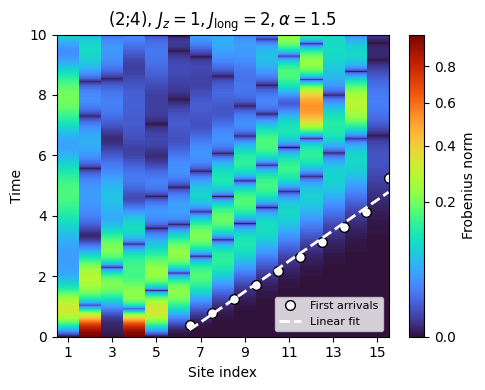

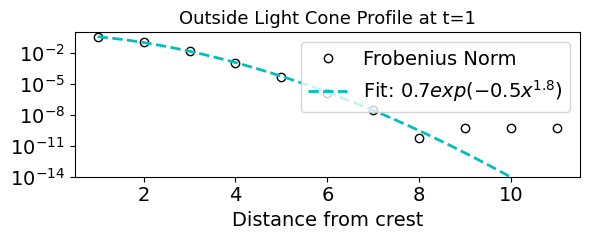

profile [3.17956513e-01 1.23126335e-01 1.65168107e-02 1.14993941e-03
 4.93669186e-05 1.44117840e-06 2.99839931e-08 6.07958128e-11
 5.45186118e-10 5.51203527e-10 5.51403367e-10]


In [25]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_mathematica_data(filename):
    """
    Load data from a Mathematica-style text file:
    {0.001707401450201651 + 0.*I, 5.646194622954682*^-9 + 0.*I, ...}
    Returns: 2D numpy array (rows = lines, cols = entries per line)
    """
    data = []
    with open(filename, "r") as f:
        for line in f:
            # Normalize Mathematica scientific notation: *^ -> e
            line = line.replace("*^", "e")

            # Remove curly braces
            line = line.strip().lstrip("{").rstrip("}")
            
            # Split by comma
            entries = line.split(",")
            
            # Extract real part (ignore imaginary part)
            row = []
            for e in entries:
                e = e.strip()
                # Remove the "+ 0.*I" if present
                e = e.split("+")[0].strip()
                try:
                    row.append(float(e))
                except ValueError:
                    pass
            if row:
                data.append(row)
    return np.array(data)


# -----------------------------
# Example usage
# -----------------------------

# Define path to the data file
data_path = os.path.join("src", "N15B0LFIMHeffa15Jlong2b1lc.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_data = load_mathematica_data(data_path)


print("Shape:", raw_data.shape)
print(raw_data[-3])  # print first two rows


# Example: dummy first arrival points
# === First arrival points (site, time) ===
arrivals = [
    (6, 0.39),
    (7, 0.80),
    (8, 1.24),
    (9, 1.70),
    (10, 2.17),
    (11, 2.65),
    (12, 3.13),
    (13, 3.62),
    (14, 4.12),
    (15, 5.24)
]





x_points = np.array([a[0] for a in arrivals])   # site indices
y_points = np.array([a[1] for a in arrivals])   # times

# === Linear fit ===
fit_params = np.polyfit(x_points, y_points, 1)
fit_fn = np.poly1d(fit_params)
x_fit = np.linspace(x_points.min(), x_points.max(), 200)
y_fit = fit_fn(x_fit)

slope, intercept = fit_params

# === Simulation step size ===
step_size = 0.001   # <-- input your step size here
steps_per_unit = 1 / step_size
n_steps = raw_data.shape[0]

# Time array (row index → physical time)
time_axis = np.arange(n_steps) / steps_per_unit
t_min, t_max = time_axis.min(), time_axis.max()

# === Heatmap ===
plt.figure(figsize=(5, 4))

im = plt.imshow(
    raw_data,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    interpolation="none",
    norm=mcolors.PowerNorm(gamma=0.5, vmin=0, vmax=raw_data.max()),
    extent=[0, raw_data.shape[1], t_min, t_max+0.001]  # <-- keep full extent
)

# Overlay first arrival points
plt.plot(x_points, y_points, 'wo', markersize=7,
         markeredgecolor="k", label="First arrivals")

# Overlay best-fit line
plt.plot(x_fit, y_fit, 'w--', linewidth=2, label="Linear fit")

# Labels
plt.colorbar(im, label="Frobenius norm")
plt.xlabel("Site index")
plt.ylabel("Time")
plt.title(r"(2;4), $J_z=1, J_{\mathrm{long}}=2, \alpha=1.5$")

# Fix site index ticks at centers
n_sites = raw_data.shape[1]
step = 2  # show every 2nd site index
positions = np.arange(0.5, n_sites, step)
labels = np.arange(1, n_sites + 1, step)

plt.xticks(positions, labels)


plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa15Jlong2b1lc.svg", bbox_inches="tight") 
plt.show()

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Pick time slice ===
time = 1  # physical time
t_index = int(time * steps_per_unit)
profile = raw_data[t_index, 4:]
sites = np.arange(1, profile.size+1)

# === Use first few points outside cone for fit ===
n_fit = 7   # number of points to use
x_fit_points = sites[:n_fit]
y_fit_points = profile[:n_fit]

# Avoid log of zero
mask = y_fit_points > 1e-14
x_fit_points = x_fit_points[mask]
y_fit_points = y_fit_points[mask]

# Model: log(y) = log(A) - a * x^p
def log_model(x, logA, a, p):
    return logA - a * (x**p)

# Fit in log space
logy = np.log(y_fit_points)
popt, _ = curve_fit(log_model, x_fit_points, logy,
                    p0=(np.log(y_fit_points.max()), 0.01, 2.0))
logA_fit, a_fit, p_fit = popt
A_fit = np.exp(logA_fit)

# Reconstruct fitted curve
x_dense = np.linspace(sites.min(), sites.max(), 300)
y_dense = A_fit * np.exp(-a_fit * x_dense**p_fit)

# === Plot semi-log (flattened aspect, bigger fonts) ===
plt.figure(figsize=(6, 2.5))  # flattened aspect
plt.semilogy(sites, profile, 'wo', markersize=6,
             markeredgecolor="k", label="Frobenius Norm")
plt.semilogy(x_dense, y_dense, 'c--', linewidth=2,
             label=fr"Fit: ${A_fit:.1f}exp({{-{a_fit:.1f} x^{{{p_fit:.1f}}}}})$")

plt.xlabel("Distance from crest", fontsize=14)
# plt.ylabel("Frobenius Norm", fontsize=12)
plt.title(f"Outside Light Cone Profile at t={time}", fontsize=13)
plt.ylim(1e-14, 1)   # y-axis range
plt.legend(fontsize=14, loc="upper right")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("plt/N15B0LFIMHeffa15Jlong2b1lcOutLC.svg", bbox_inches="tight") 
plt.show()

print("profile",profile)